# Loading the dataset

In [ ]:
from urllib.request import urlretrieve
import os, ssl

# directory path to store data
output_relative_dir = './data'

# check if it exists as it makedir will raise an error if it does exist
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)

In [ ]:
YEAR = '2021'
MONTHS = range(11,13)
URL_TEMPLATE = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"#year-month.parquet

In [ ]:
tlc_output_dir = output_relative_dir

for month in MONTHS:
    # 0-fill i.e 1 -> 01, 2 -> 02, etc
    month = str(month).zfill(2) 
    print(f"Begin month {month}")
    
    # generate url
    url = f'{URL_TEMPLATE}{YEAR}-{month}.parquet'
    # generate output location and filename
    output_dir = f"{tlc_output_dir}/{YEAR}-{month}.parquet"

    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
        ssl._create_default_https_context = ssl._create_unverified_context
    # download
    urlretrieve(url, output_dir) 
    
    print(f"Completed month {month}")

In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/18 22:05:39 WARN Utils: Your hostname, Harshitas-MacBook-Air-8.local resolves to a loopback address: 127.0.0.1; using 192.168.0.227 instead (on interface en0)
22/08/18 22:05:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/18 22:05:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/18 22:05:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
sdf = spark.read.parquet('./data')

In [17]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium

In [14]:
zones = pd.read_csv("./data/taxi_data/taxi+_zone_lookup.csv")
sf = gpd.read_file("./data/taxi_data/taxi_zones.shp")
# attribute tute code
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [16]:
gdf = gpd.GeoDataFrame(pd.merge(zones, sf, on='LocationID', how='inner'))
# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']] \
    .drop_duplicates('LocationID').to_json()

In [ ]:
gdf["latitude"] = gdf["geometry"].centroid.y
gdf["longitude"] = gdf["geometry"].centroid.x

In [113]:
gdf.head()

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,latitude,longitude
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",40.691831,-74.174000
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",40.616745,-73.831299
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",40.864474,-73.847422
3,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",40.723752,-73.976968
4,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",40.552659,-74.188484


In [114]:
import time, math
from datetime import date

def extract_date_time(date_str):
    """
    date string is of the format yyyy-mm-dd hh:mm:ss, e.g., 2022-04-01 00:21:13
    Follows 24-hr time format.
    Return a tuple of the form (time_str, hour_bin, month, date, day, isWeekend)
    """
    date_time = date_str.split()
    if len(date_time) != 2:
        return (None, None, None)

    dateL = list(map(int, date_time[0].split("-")))
    timeL = list(map(int, date_time[1].split(":")))
    
    return dateL, timeL
    

def extract_features(date_str):
    dateL, timeL = extract_date_time(date_str)
    
    time_str = f'{timeL[0]}:{timeL[1]}'
    hour_bin = int(timeL[0])

    dateV = date(dateL[0], dateL[1], dateL[2])

    day_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
                4: "Friday", 5: "Saturday", 6: "Sunday"}
    day = day_dict[dateV.weekday()]
    
    is_weekend = 0
    if day in ["Saturday", "Sunday"]:
        is_weekend = 1

    return (time_str, hour_bin, dateV.month, dateV.day, day, is_weekend)

In [52]:
extract_date_time("2022-04-01 00:21:13")
# date(2022, 8, 19).weekday()

('0:21', 0, 'Friday', 0)

In [85]:
# clean rows with invalid values accoring to the data dictionaries
sdf_clean = sdf.filter((sdf["fare_amount"] < 0) | 
    (sdf["extra"] < 0) | 
    (sdf["mta_tax"] < 0) | 
    (sdf["tip_amount"] < 0) | 
    (sdf["tolls_amount"] < 0) | 
    (sdf["improvement_surcharge"] < 0) | 
    (sdf["total_amount"] < 0) | 
    (sdf["congestion_surcharge"] < 0) | 
    (sdf["airport_fee"] < 0) | 
    (sdf["VendorID"] > 2) | 
    (sdf["VendorID"] < 1) |
    (sdf["passenger_count"] < 1) | 
    (sdf["trip_distance"] <= 0) | 
    (sdf["RatecodeID"] > 6) | 
    (sdf["RatecodeID"] < 1) | 
    (sdf["payment_type"] > 6) | 
    (sdf["payment_type"] < 1)
    )

In [87]:
small_df = sdf_clean.sample(0.05, seed=None)
small_df = small_df.toPandas()

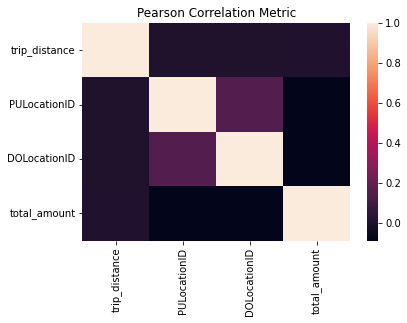

In [115]:
# sdf.filter(F.col('passenger_count') >= 2).count()
CORR_COLS = ["trip_distance", "PULocationID", "DOLocationID", "total_amount"]
sns.heatmap(small_df[CORR_COLS].corr())

plt.title('Pearson Correlation Metric')
plt.show()

In [89]:
small_df = small_df \
    .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    .drop('LocationID', axis=1)

In [96]:
sdf_clean.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

